In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import numpy as np
from py4j.java_gateway import JavaGateway, GatewayParameters

In [2]:
# Retrieve OpenSHA objects from the JavaGateway

gateway = JavaGateway(gateway_parameters=GatewayParameters(auto_field=True, auto_convert=True))
app = gateway.entry_point
rup_set = app.loadRupSet("rupSetBruceRundir5883.zip")
sections = rup_set.getFaultSectionDataList()
coulomb = app.getCoulombTester(rup_set, "stiffnessCaches")
coulomb.setupStiffness()
filters = coulomb.getFilters()
jumps = coulomb.getJumps(rup_set)

agg_calc_1 = filters[1].getAggCalc()
threshold_1 = filters[1].getThreshold()



In [3]:
# area calculations are expensive, we isolate them in this cell to avoid repeats
sqk = 1.0/1000000  

def rupture_area(rupture):
    return sum([s.getArea(False) * sqk for s in rupture.buildOrderedSectionList()])

# total area of subduction component
sub_areas = np.array([rupture_area(j.fromRupture) for j in jumps])
# total area of crustal component
cru_areas = np.array([rupture_area(j.toRupture) for j in jumps])

In [4]:
# Collect rupture stats

# filter passes
filter_0_passes = np.array([filters.get(0).apply(j, False).isPass() for j in jumps])
filter_1_passes = np.array([filters.get(1).apply(j, False).isPass() for j in jumps])

def filter_stats(agg_calc, threshold, ruptureId):
    sectionIds = rup_set.getSectionsIndicesForRup(ruptureId)
    rupture = [sections.get(s) for s in sectionIds]
    subduction = [s for s in rupture if "row:" in s.getSectionName()]
    crustal = [s for s in rupture if "row:" not in s.getSectionName()]
    all_sections = subduction + crustal
    return [
        # area of passing target crustal sections
        sum([s.getArea(False) * sqk for s in crustal if agg_calc.calc(subduction, [s]) >= threshold]),
        # subduction->crustal stiffness, can be used to check if filter would pass
        agg_calc.calc(subduction, crustal),
        agg_calc.calc(crustal, subduction),
        sum([s.getArea(False) * sqk for s in crustal if agg_calc.calc(all_sections, [s]) >= threshold]),
        sum([s.getArea(False) * sqk for s in subduction if agg_calc.calc(all_sections, [s]) >= threshold]),
      
    ]

filter_1_stats = [filter_stats(agg_calc_1, threshold_1, r) for r in range(rup_set.getNumRuptures())]
filter_1_pass_area = np.array([ps for (ps, sc, cs, aa, sa) in filter_1_stats])
filter_1_pass_full_stiffness_area = np.array([aa for (ps, sc, cs, aa, sa) in filter_1_stats])
filter_1_pass_full_stiffness_area_sub = np.array([sa for (ps, sc, cs, aa, sa) in filter_1_stats])



In [5]:
coulomb.saveCache()

MultiRuptureFractCoulombPositiveFilter pass count 3
MultiRuptureNetCoulombPositiveFilter pass count 173


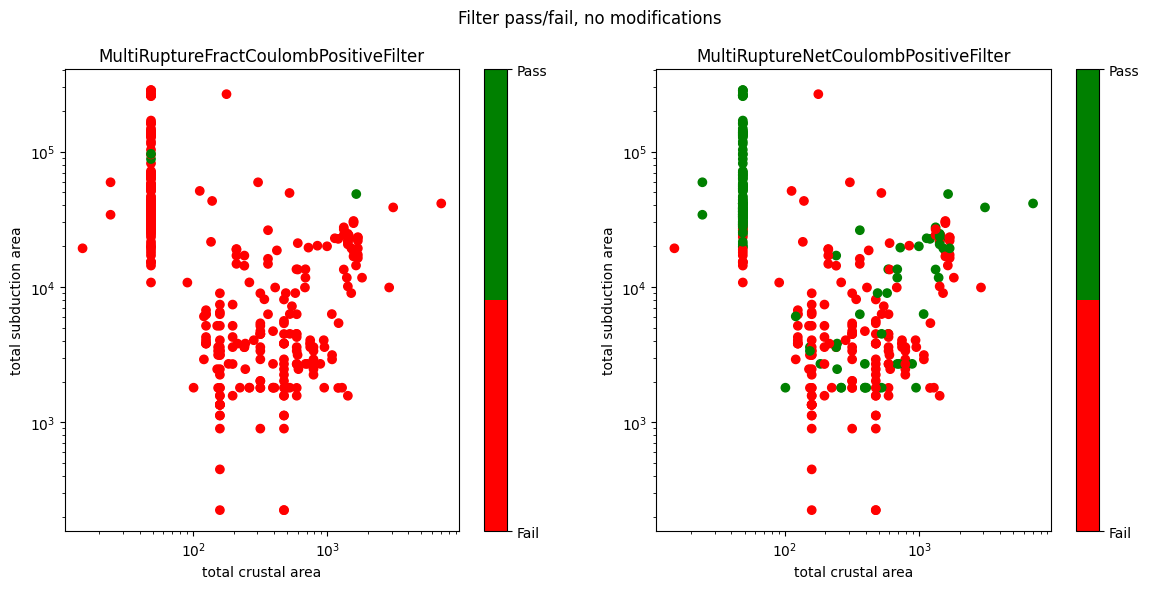

In [5]:
cmap = colors.ListedColormap(['red', 'green'])
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Filter pass/fail, no modifications")

scatter = axs[0].scatter(cru_areas, sub_areas, c=filter_0_passes, cmap=cmap)
axs[0].set_title("MultiRuptureFractCoulombPositiveFilter")
axs[0].set_ylabel("total subduction area")
axs[0].set_yscale('log')
axs[0].set_xlabel('total crustal area')
axs[0].set_xscale('log')
cbar = fig.colorbar(scatter, ticks=[0,1])
cbar.ax.set_yticklabels(['Fail', 'Pass'])

scatter = axs[1].scatter(cru_areas, sub_areas, c=filter_1_passes, cmap=cmap)
axs[1].set_title("MultiRuptureNetCoulombPositiveFilter")
axs[1].set_ylabel("total subduction area")
axs[1].set_yscale('log')
axs[1].set_xlabel('total crustal area')
axs[1].set_xscale('log')
cbar = fig.colorbar(scatter, ticks=[0,1])
cbar.ax.set_yticklabels(['Fail', 'Pass'])

pass_count_0 = sum(p for p in filter_0_passes)
pass_count_1 = sum(p for p in filter_1_passes)
print("MultiRuptureFractCoulombPositiveFilter pass count", pass_count_0)
print("MultiRuptureNetCoulombPositiveFilter pass count", pass_count_1)

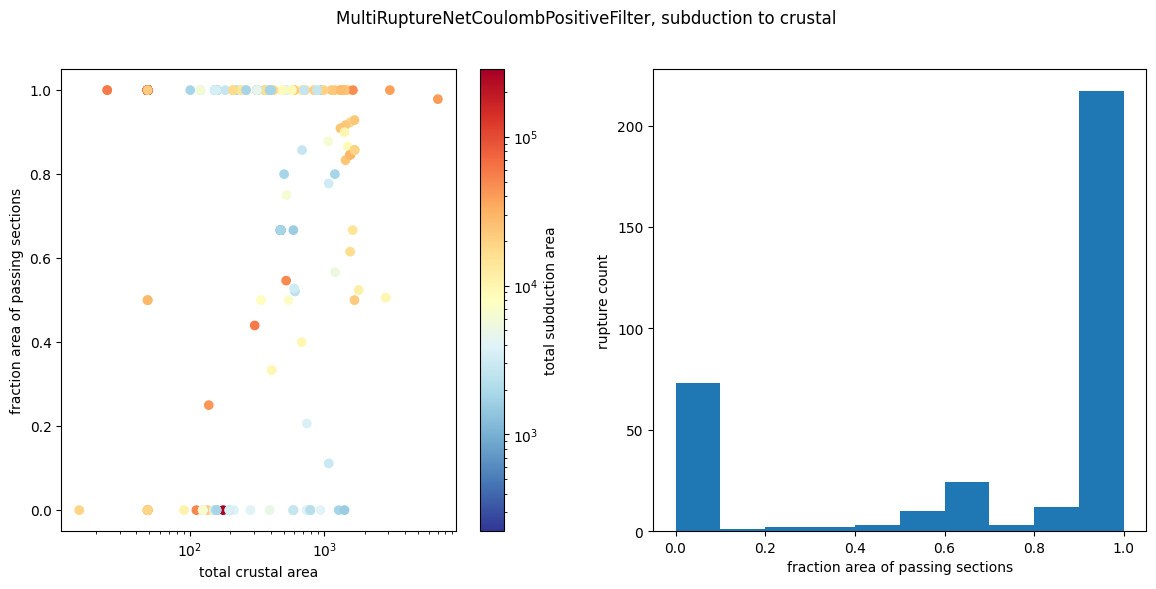

In [6]:
fraction = np.divide(filter_1_pass_area, cru_areas)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
scatter = axs[0].scatter(cru_areas, fraction, c=sub_areas, cmap='RdYlBu_r', norm=colors.LogNorm())
fig.suptitle("MultiRuptureNetCoulombPositiveFilter, subduction to crustal")
axs[0].set_ylabel('fraction area of passing sections')
#plt.yscale('log')
axs[0].set_xlabel('total crustal area')
axs[0].set_xscale('log')
cbar = fig.colorbar(scatter)
cbar.set_label("total subduction area")

hist = axs[1].hist(fraction)
axs[1].set_xlabel('fraction area of passing sections')
axs[1].set_ylabel('rupture count')
plt.show()

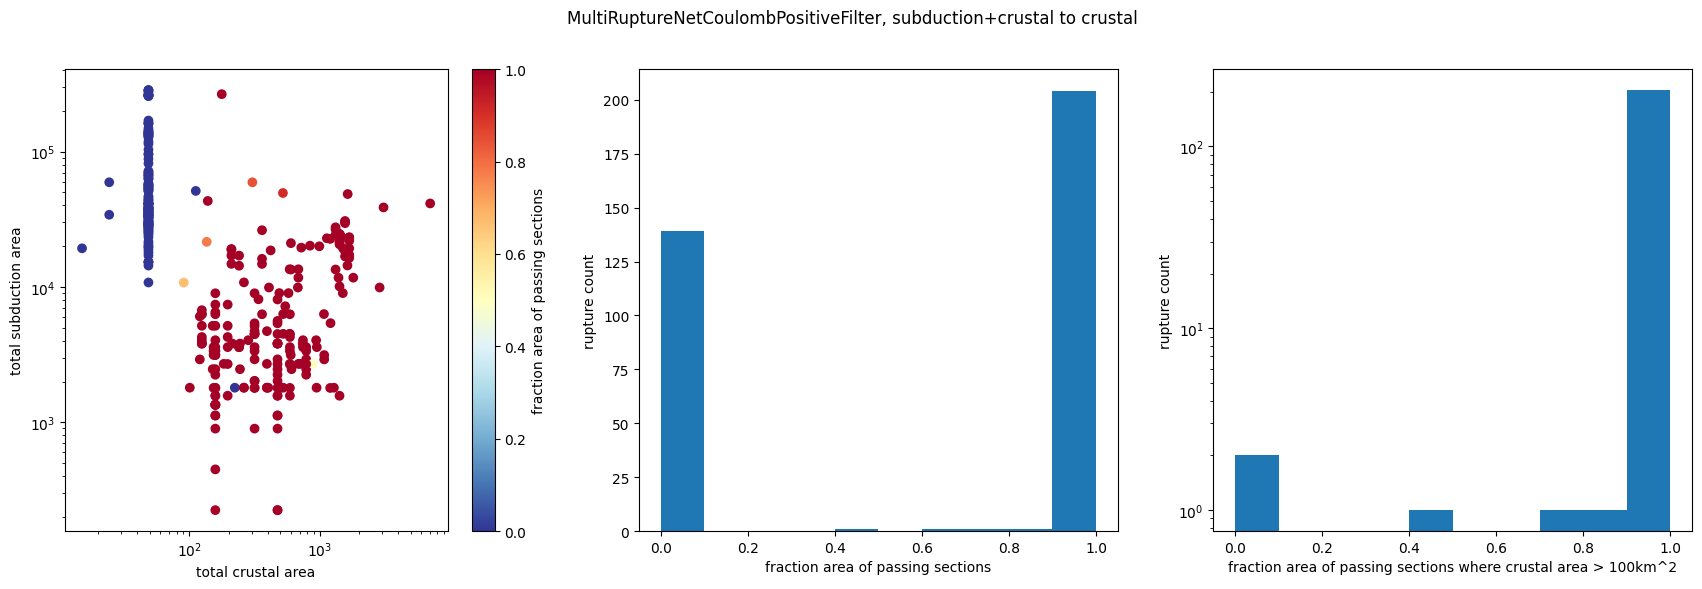

In [7]:
fraction = np.divide(filter_1_pass_full_stiffness_area, cru_areas)
fig, axs = plt.subplots(1, 3, figsize=(21, 6))
scatter = axs[0].scatter(cru_areas, sub_areas, c=fraction, cmap='RdYlBu_r')
fig.suptitle("MultiRuptureNetCoulombPositiveFilter, subduction+crustal to crustal")
axs[0].set_ylabel('total subduction area')
axs[0].set_yscale('log')
axs[0].set_xlabel('total crustal area')
axs[0].set_xscale('log')
cbar = fig.colorbar(scatter)
cbar.set_label("fraction area of passing sections")

hist = axs[1].hist(fraction)
axs[1].set_xlabel('fraction area of passing sections')
axs[1].set_ylabel('rupture count')

big_fractions = [fraction[i] for i in range(len(fraction)) if cru_areas[i] > 100]
hist = axs[2].hist(big_fractions)
axs[2].set_xlabel('fraction area of passing sections where crustal area > 100km^2')
axs[2].set_ylabel('rupture count')
axs[2].set_yscale('log')

plt.show()

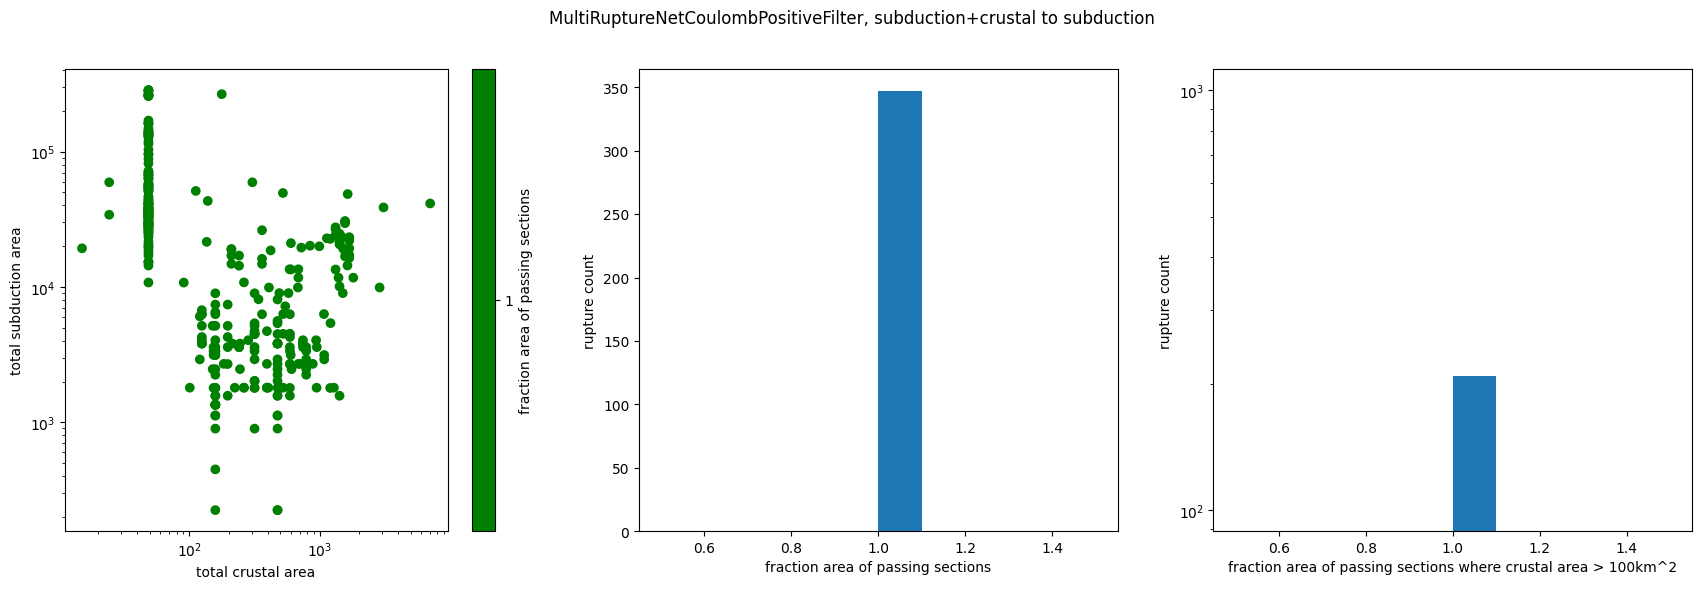

In [10]:
fraction = np.divide(filter_1_pass_full_stiffness_area_sub, sub_areas)
fig, axs = plt.subplots(1, 3, figsize=(21, 6))
cmap = colors.ListedColormap(['green'])
scatter = axs[0].scatter(cru_areas, sub_areas, c=fraction, cmap=cmap)
fig.suptitle("MultiRuptureNetCoulombPositiveFilter, subduction+crustal to subduction")
axs[0].set_ylabel('total subduction area')
axs[0].set_yscale('log')
axs[0].set_xlabel('total crustal area')
axs[0].set_xscale('log')
cbar = fig.colorbar(scatter, ticks=[0,1])
cbar.set_label("fraction area of passing sections")

hist = axs[1].hist(fraction)
axs[1].set_xlabel('fraction area of passing sections')
axs[1].set_ylabel('rupture count')

big_fractions = [fraction[i] for i in range(len(fraction)) if cru_areas[i] > 100]
hist = axs[2].hist(big_fractions)
axs[2].set_xlabel('fraction area of passing sections where crustal area > 100km^2')
axs[2].set_ylabel('rupture count')
axs[2].set_yscale('log')

plt.show()